## Figure 2B
## Figure S4, S6A

## Helper codes: run below cells before any of the other cells. 

In [2]:
import mat73
import h5py
import hdf5storage as st
# from pymatreader import read_mat
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.stats import wilcoxon, norm, kruskal, tukey_hsd, mannwhitneyu, sem, rankdata, spearmanr
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.special import factorial, gammaln
from scipy.cluster.hierarchy import fcluster

import seaborn as sns
from copy import deepcopy as dc
from statsmodels.stats.multitest import multipletests
from itertools import combinations, combinations_with_replacement, permutations, product

from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression as logit
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import Isomap

from umap import UMAP

import math
# from bayes_opt importOptimization

# from libsvm import svmutil

# import torch
# import torch.nn as nn
# import torch.optim as optim

# from pycaret.classification import *

c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# loading variables

# ABO Neuropixels
with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_RS = resp_matrix_ep_RS_all['list_rate_RS'].copy()
    list_rate_RS_dr = resp_matrix_ep_RS_all['list_rate_RS_dr'].copy()
    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_rate_all_dr = resp_matrix_ep_RS_all['list_rate_all_dr'].copy()
    list_slopes_RS_an_loglog = resp_matrix_ep_RS_all['list_slopes_RS_an_loglog'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()

    sess_inds_qual_all = resp_matrix_ep_RS_all['sess_inds_qual_all'].copy()
    sess_inds_qual_all_dr = resp_matrix_ep_RS_all['sess_inds_qual_all_dr'].copy()

    print(resp_matrix_ep_RS_all['tree_variables'])

with open('invalid_unit_sess.pickle', 'rb') as f:
    invalid_unit_sess = pickle.load(f)

    list_invalid_units_visp = invalid_unit_sess['list_invalid_units_visp'].copy()
    list_invalid_units_HVA = invalid_unit_sess['list_invalid_units_HVA'].copy()
    list_invalid_sess_visp = invalid_unit_sess['list_invalid_sess_visp'].copy()
    list_invalid_sess_HVA = invalid_unit_sess['list_invalid_sess_HVA'].copy()
    sess_inds_mapBO = invalid_unit_sess['sess_inds_mapBO'].copy()

['list_rate_RS', 'list_rate_RS_dr', 'list_rate_all', 'list_rate_all_dr', 'list_slopes_RS_an_loglog', 'list_slopes_all_att_loglog', 'list_slopes_all_an_loglog', 'list_slopes_stat_all_an_loglog', 'list_slopes_mov_all_an_loglog', 'sess_inds_qual_RS', 'sess_inds_qual_RS_dr', 'sess_inds_qual_all', 'sess_inds_qual_all_dr']


In [4]:
def compute_mean_var_trial(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = pd.concat([trial_mean] * label_cnt_dict[trial_type], axis=1)
        list_trial_var[trial_ind] = pd.concat([trial_var] * label_cnt_dict[trial_type], axis=1)

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [5]:
def compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = trial_mean.copy()
        list_trial_var[trial_ind] = trial_var.copy()

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [6]:
# Function to compute cosine similarity
def cos_sim(x, y):
    # x and y are 1D vectors

    # Remove NaN
    x, y = np.array(x), np.array(y)
    bool_notnan = np.logical_and(~np.isnan(x), ~np.isnan(y))
    x, y = x[bool_notnan].copy(), y[bool_notnan].copy()

    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [7]:
# Function for column normalization
def normc(matrix):
    '''For 2D matrix'''

    matrix_normalized = matrix / np.linalg.norm(matrix, axis=0)

    return matrix_normalized

In [8]:
def annotate_lineplot_significance(significant_values, axes, ax_ind, line_height_ratio, color):

    if len(significant_values) > 0:

        # Initialize start and end points of lines
        start = None
        lines = []
        dots = []

        # Loop through sorted significant_values to group them into lines or dots
        for i in range(len(significant_values) - 1):
            if start is None:
                start = significant_values[i]

            # Check if the next value is part of the same line
            if significant_values[i + 1] - significant_values[i] > 0.1 + 1e-9:  # Threshold for a gap; add pseudo-value to avoid floating point issue
                if start == significant_values[i]:
                    dots.append(start)  # Isolated point
                else:
                    lines.append((start, significant_values[i]))  # Line segment
                start = None

        # Check the last value
        if start is None:
            dots.append(significant_values[-1])
        else:
            lines.append((start, significant_values[-1]))

        # Plot lines and dots
        for line in lines:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)  # Draw a line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
                
        for dot in dots:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)  # Draw a very short line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)

In [9]:
# # Collect decoding for each session (SVM/logit/Bayesian)

# decoder_type = 'SVM'

# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# num_trial_types = 119
# num_trials = 50

# list_mean_confusion_test = np.full((num_sess, num_trial_types, num_trial_types), np.nan)
# list_mean_accuracy = np.full(num_sess, np.nan)
# list_mean_confusion_test_RRneuron2 = np.full((len(list_target_slopes), num_sess, num_trial_types, num_trial_types), np.nan)
# list_mean_accuracy_RRneuron2 = np.full((len(list_target_slopes), num_sess), np.nan)
# for sess_ind in range(num_sess):
#     file_name = decoder_type + '_decoding_ABO_allstim_shuf_' + str(sess_ind) + '.pickle'
    
#     with open(file_name, 'rb') as f:
#         decoding_ABO = pickle.load(f)

#         list_mean_confusion_test[sess_ind] = decoding_ABO['mean_confusion_test_asis'].copy()
#         list_mean_accuracy[sess_ind] = decoding_ABO['mean_accuracy_asis']
#         list_mean_confusion_test_RRneuron2[:, sess_ind] = decoding_ABO['list_mean_confusion_test_RRneuron'].copy()
#         list_mean_accuracy_RRneuron2[:, sess_ind] = decoding_ABO['list_mean_accuracy_RRneuron'].copy()

# save_file_name = decoder_type + '_decoding_ABO_allstim_shuf_all3.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_mean_confusion_test', 'list_mean_accuracy', 'list_mean_confusion_test_RRneuron2', 'list_mean_accuracy_RRneuron2'],
#                     'list_mean_confusion_test': list_mean_confusion_test, 'list_mean_accuracy': list_mean_accuracy,
#                     'list_mean_confusion_test_RRneuron2': list_mean_confusion_test_RRneuron2, 'list_mean_accuracy_RRneuron2': list_mean_accuracy_RRneuron2}, f)

In [10]:
# # Collect decoding for each slope (SVM/Bayesian, HVA)

# decoder_type = 'SVM'

# list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# num_trial_types = 119

# list_mean_confusion_test_RRneuron_HVA2 = {hva: np.empty(len(list_target_slopes), dtype=object) for hva in list_HVA_names}
# list_mean_accuracy_RRneuron_HVA2 = {hva: np.empty(len(list_target_slopes), dtype=object) for hva in list_HVA_names}
# for area_ind, area in enumerate(list_HVA_names):
#     for slope_ind, target_slope in enumerate(list_target_slopes):
#         file_name = decoder_type + '_decoding_ABO_HVA_' + str(slope_ind) + '.pickle'
        
#         with open(file_name, 'rb') as f:
#             decoding_ABO = pickle.load(f)
#             if slope_ind == 0:
#                 list_mean_confusion_test_HVA = decoding_ABO['list_mean_confusion_test_HVA'].copy()
#                 list_mean_accuracy_HVA = decoding_ABO['list_mean_accuracy_HVA'].copy()
#             list_mean_confusion_test_RRneuron_HVA2[area][slope_ind] = decoding_ABO['list_mean_confusion_test_RRneuron_HVA'][area].copy()
#             list_mean_accuracy_RRneuron_HVA2[area][slope_ind] = decoding_ABO['list_mean_accuracy_RRneuron_HVA'][area].copy()

# save_file_name = decoder_type + '_decoding_ABO_HVA_all2.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_mean_confusion_test_HVA', 'list_mean_accuracy_HVA', 'list_mean_confusion_test_RRneuron_HVA2', 'list_mean_accuracy_RRneuron_HVA2'],
#                     'list_mean_confusion_test_HVA': list_mean_confusion_test_HVA, 'list_mean_accuracy_HVA': list_mean_accuracy_HVA,
#                     'list_mean_confusion_test_RRneuron_HVA2': list_mean_confusion_test_RRneuron_HVA2, 'list_mean_accuracy_RRneuron_HVA2': list_mean_accuracy_RRneuron_HVA2}, f)

## Codes for figures

## Figure 2B

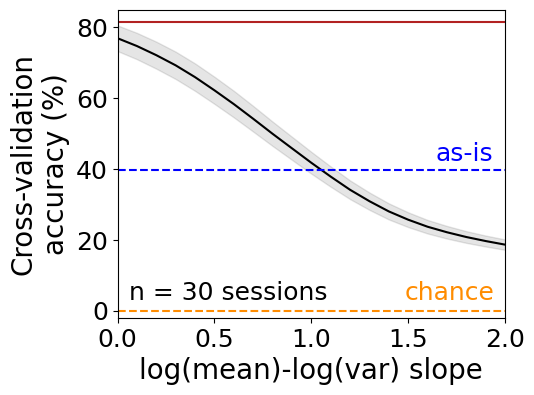

In [11]:
# decoding plot across slopes (ABO, SVM)

decoder_type = 'SVM'

save_file_name = decoder_type + '_decoding_ABO_allstim_all.pickle' # randomness matched (slope 0~2), logit/SVM max_iter=1000/-1
# save_file_name = decoder_type + '_decoding_ABO_allstim_all2.pickle' # randomness matched (slope 0~2), logit/SVM max_iter=100
save_file_name = decoder_type + '_decoding_ABO_allstim_all3.pickle' # randomness matched (slope 0~2), SVM max_iter=1000
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    decoding_ABO_all = pickle.load(f)

    # list_mean_confusion_test = dc(decoding_ABO_all['list_mean_confusion_test'])
    list_mean_accuracy = dc(decoding_ABO_all['list_mean_accuracy'])
    # list_mean_confusion_test_RRneuron2 = dc(decoding_ABO_all['list_mean_confusion_test_RRneuron2'])
    list_mean_accuracy_RRneuron2 = dc(decoding_ABO_all['list_mean_accuracy_RRneuron2'])

num_sess = 32

# Exclude low quality sessions (0, 6)
list_mean_accuracy = 100*np.array(list_mean_accuracy)
list_mean_accuracy_RRneuron2 = 100*np.stack(list_mean_accuracy_RRneuron2)
list_mean_accuracy = np.concatenate([list_mean_accuracy[1:6], list_mean_accuracy[7:]], axis=0)
list_mean_accuracy_RRneuron2 = np.concatenate([list_mean_accuracy_RRneuron2[:, 1:6], list_mean_accuracy_RRneuron2[:, 7:]], axis=1)

num_sess = list_mean_accuracy.shape[0]

# # session filtering based on number of neurons
# list_mean_accuracy = np.array(list_mean_accuracy)[sess_inds_qual_all].copy()
# list_mean_accuracy_RRneuron2 = np.stack(list_mean_accuracy_RRneuron2)[:, sess_inds_qual_all].copy()

# num_sess = len(sess_inds_qual_all)

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# Wilcoxon signed-rank test (RRneuron, ABO)
list_pvals_RRneuron2 = np.zeros(len(list_target_slopes)) # test accuracy
for slope_ind, slope in enumerate(list_target_slopes):
    list_pvals_RRneuron2[slope_ind] = list(wilcoxon(list_mean_accuracy, list_mean_accuracy_RRneuron2[slope_ind]))[1]
list_pvals_RRneuron2 = np.array(multipletests(list_pvals_RRneuron2, method='holm')[1]) # multiple comparisons correction

# As-is vs. RRneuron test accuracy (averaged across sessions)

fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

# test accuracy

list_means_accuracy = np.array([np.mean(list_mean_accuracy_RRneuron2[slope_ind]) \
                       for slope_ind in range(len(list_target_slopes))])
list_errs_accuracy = np.array([sem(list_mean_accuracy_RRneuron2[slope_ind]) \
                      for slope_ind in range(len(list_target_slopes))])

axes[0].plot(list_target_slopes, list_means_accuracy, color='k')
# axes[0].errorbar(list_target_slopes, list_means_accuracy, yerr=list_errs_accuracy, \
#             fmt='.', color="m")
axes[0].fill_between(list_target_slopes, list_means_accuracy-list_errs_accuracy, \
                     list_means_accuracy+list_errs_accuracy, color='k', alpha=0.1)

axes[0].axhline(np.mean(list_mean_accuracy), c='b', linestyle='--') # as-is average

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
axes[0].set_ylim(-2, 85)
axes[0].set_yticks(100*np.arange(0, 0.81, 0.2))
annotate_lineplot_significance(list_target_slopes[list_pvals_RRneuron2 < 0.05], axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')
axes[0].axhline(1/119, c='darkorange', linestyle='--') # chance level

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=20)
axes[0].set_ylabel('Cross-validation\naccuracy (%)', fontsize=20)
axes[0].tick_params('both', labelsize=18)

height = (np.mean(list_mean_accuracy)-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.82, height+0.03), xycoords='axes fraction', fontsize=18, color='b')
axes[0].annotate(f'n = {num_sess} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=18, color='k')
axes[0].annotate(f'chance', xy=(0.74, 0.06), xycoords='axes fraction', fontsize=18, color='darkorange')

axes[0].set_xlim(0, 2)

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\decoding.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\decoding.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure S4C left

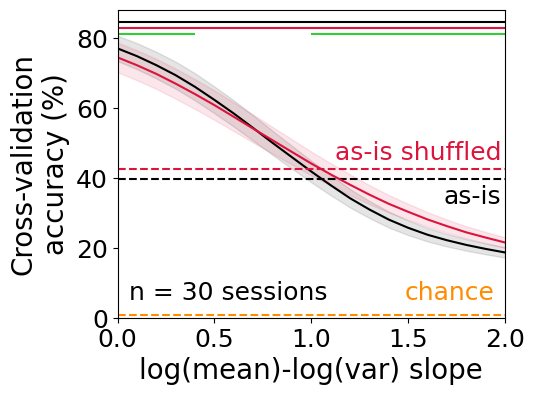

In [12]:
# decoding plot across slopes (ABO, SVM)

decoder_type = 'SVM'

save_file_name = decoder_type + '_decoding_ABO_allstim_all.pickle' # randomness matched (slope 0~2), logit/SVM max_iter=1000/-1
# save_file_name = decoder_type + '_decoding_ABO_allstim_all2.pickle' # randomness matched (slope 0~2), logit/SVM max_iter=100
save_file_name = decoder_type + '_decoding_ABO_allstim_all3.pickle' # randomness matched (slope 0~2), SVM max_iter=1000
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    decoding_ABO_all = pickle.load(f)

    # list_mean_confusion_test = dc(decoding_ABO_all['list_mean_confusion_test'])
    list_mean_accuracy = dc(decoding_ABO_all['list_mean_accuracy'])
    # list_mean_confusion_test_RRneuron2 = dc(decoding_ABO_all['list_mean_confusion_test_RRneuron2'])
    list_mean_accuracy_RRneuron2 = dc(decoding_ABO_all['list_mean_accuracy_RRneuron2'])

save_file_name = decoder_type + '_decoding_ABO_allstim_shuf_all.pickle' # shuffled, randomness matched (slope 0~2), logit/SVM max_iter=1000/-1
# save_file_name = decoder_type + '_decoding_ABO_allstim_shuf_all2.pickle' # shuffled, randomness matched (slope 0~2), SVM max_iter=100
save_file_name = decoder_type + '_decoding_ABO_allstim_shuf_all3.pickle' # shuffled, randomness matched (slope 0~2), SVM max_iter=1000
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    decoding_ABO_all = pickle.load(f)

    # list_mean_confusion_test = dc(decoding_ABO_all['list_mean_confusion_test'])
    list_mean_accuracy_shuf = dc(decoding_ABO_all['list_mean_accuracy'])
    # list_mean_confusion_test_RRneuron2 = dc(decoding_ABO_all['list_mean_confusion_test_RRneuron2'])
    list_mean_accuracy_RRneuron2_shuf = dc(decoding_ABO_all['list_mean_accuracy_RRneuron2'])

num_sess = 32
num_trial_types = 119

# Exclude low quality sessions (0, 6)
list_mean_accuracy = np.array(list_mean_accuracy)
list_mean_accuracy_RRneuron2 = np.stack(list_mean_accuracy_RRneuron2)
list_mean_accuracy = np.concatenate([list_mean_accuracy[1:6], list_mean_accuracy[7:]], axis=0)
list_mean_accuracy_RRneuron2 = np.concatenate([list_mean_accuracy_RRneuron2[:, 1:6], list_mean_accuracy_RRneuron2[:, 7:]], axis=1)

list_mean_accuracy_shuf = np.array(list_mean_accuracy_shuf)
list_mean_accuracy_RRneuron2_shuf = np.stack(list_mean_accuracy_RRneuron2_shuf)
list_mean_accuracy_shuf = np.concatenate([list_mean_accuracy_shuf[1:6], list_mean_accuracy_shuf[7:]], axis=0)
list_mean_accuracy_RRneuron2_shuf = np.concatenate([list_mean_accuracy_RRneuron2_shuf[:, 1:6], list_mean_accuracy_RRneuron2_shuf[:, 7:]], axis=1)

num_sess = list_mean_accuracy.shape[0]
list_mean_accuracy = 100 * list_mean_accuracy
list_mean_accuracy_RRneuron2 = 100 * list_mean_accuracy_RRneuron2
list_mean_accuracy_shuf = 100 * list_mean_accuracy_shuf
list_mean_accuracy_RRneuron2_shuf = 100 * list_mean_accuracy_RRneuron2_shuf

# # session filtering based on number of neurons
# list_mean_accuracy = np.array(list_mean_accuracy)[sess_inds_qual_all].copy()
# list_mean_accuracy_RRneuron2 = np.stack(list_mean_accuracy_RRneuron2)[:, sess_inds_qual_all].copy()
# list_mean_accuracy_shuf = np.array(list_mean_accuracy_shuf)[sess_inds_qual_all].copy()
# list_mean_accuracy_RRneuron2_shuf = np.stack(list_mean_accuracy_RRneuron2_shuf)[:, sess_inds_qual_all].copy()

# num_sess = len(sess_inds_qual_all)

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# Wilcoxon signed-rank test (RRneuron, ABO)
list_pvals_RRneuron2 = np.zeros(len(list_target_slopes)) # test accuracy
list_pvals_RRneuron2_shuf = np.zeros(len(list_target_slopes))
list_pvals_RRneuron2_toshuf = np.zeros(len(list_target_slopes))
for slope_ind, slope in enumerate(list_target_slopes):
    list_pvals_RRneuron2[slope_ind] = list(wilcoxon(list_mean_accuracy, list_mean_accuracy_RRneuron2[slope_ind]))[1]
    list_pvals_RRneuron2_shuf[slope_ind] = list(wilcoxon(list_mean_accuracy_shuf, list_mean_accuracy_RRneuron2_shuf[slope_ind]))[1]
    list_pvals_RRneuron2_toshuf[slope_ind] = list(wilcoxon(list_mean_accuracy_RRneuron2[slope_ind], list_mean_accuracy_RRneuron2_shuf[slope_ind]))[1]
list_pvals_RRneuron2 = np.array(multipletests(list_pvals_RRneuron2, method='holm')[1]) # multiple comparisons correction
list_pvals_RRneuron2_shuf = np.array(multipletests(list_pvals_RRneuron2_shuf, method='holm')[1])
list_pvals_RRneuron2_toshuf = np.array(multipletests(list_pvals_RRneuron2_toshuf, method='holm')[1])

# As-is vs. RRneuron test accuracy (averaged across sessions)

fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

# test accuracy

# 1. not shuffled

list_means_accuracy = np.array([np.mean(list_mean_accuracy_RRneuron2[slope_ind]) \
                       for slope_ind in range(len(list_target_slopes))])
list_errs_accuracy = np.array([sem(list_mean_accuracy_RRneuron2[slope_ind]) \
                      for slope_ind in range(len(list_target_slopes))])

axes[0].plot(list_target_slopes, list_means_accuracy, color='k')
# axes[0].errorbar(list_target_slopes, list_means_accuracy, yerr=list_errs_accuracy, \
#             fmt='.', color="m")
axes[0].fill_between(list_target_slopes, list_means_accuracy-list_errs_accuracy, \
                     list_means_accuracy+list_errs_accuracy, color='k', alpha=0.1)

axes[0].axhline(np.mean(list_mean_accuracy), c='k', linestyle='--') # as-is average

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
# SVM, logit
axes[0].set_ylim(0, 85)
axes[0].set_ylim(0, 88) # with shuffled
axes[0].set_yticks(np.arange(0, 81, 20))
annotate_lineplot_significance(list_target_slopes[list_pvals_RRneuron2 < 0.05], axes=axes, ax_ind=0, line_height_ratio=0.96, color='k')
axes[0].axhline(1/num_trial_types*100, c='darkorange', linestyle='--') # chance level

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=20)
axes[0].set_ylabel('Cross-validation\naccuracy (%)', fontsize=20)
axes[0].tick_params('both', labelsize=18)

# 2. shuffled
list_means_accuracy = np.array([np.mean(list_mean_accuracy_RRneuron2_shuf[slope_ind]) \
                       for slope_ind in range(len(list_target_slopes))])
list_errs_accuracy = np.array([sem(list_mean_accuracy_RRneuron2_shuf[slope_ind]) \
                      for slope_ind in range(len(list_target_slopes))])

axes[0].plot(list_target_slopes, list_means_accuracy, color='crimson')
axes[0].fill_between(list_target_slopes, list_means_accuracy-list_errs_accuracy, \
                     list_means_accuracy+list_errs_accuracy, color='crimson', alpha=0.1)

# significance
# axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
# axes[0].set_ylim(0, axes[0].get_ylim()[1])
annotate_lineplot_significance(list_target_slopes[list_pvals_RRneuron2_shuf < 0.05], axes=axes, ax_ind=0, line_height_ratio=0.94, color='crimson')
annotate_lineplot_significance(list_target_slopes[list_pvals_RRneuron2_toshuf < 0.05], axes=axes, ax_ind=0, line_height_ratio=0.92, color='limegreen')
axes[0].axhline(np.mean(list_mean_accuracy_shuf), c='crimson', linestyle='--') # as-is average

height = (np.mean(list_mean_accuracy)-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.84, height-0.08), xycoords='axes fraction', fontsize=18, color='k')
height_shuf = (np.mean(list_mean_accuracy_shuf)-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
axes[0].annotate('as-is shuffled', xy=(0.56, height_shuf+0.03), xycoords='axes fraction', fontsize=18, color='crimson')
axes[0].annotate(f'n = {num_sess} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=18, color='k')
axes[0].annotate(f'chance', xy=(0.74, 0.06), xycoords='axes fraction', fontsize=18, color='darkorange')

axes[0].set_xlim(0, 2)

plt.subplots_adjust(wspace=0.4, hspace=0.3) 
plt.show()

## Figure S6A

In [11]:
# HVA에서 check low quality session (all-zero trials exceed 10% of total trials)
with open('resp_matrix_ep_HVA_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_HVA_allensdk = pickle.load(f)

    list_rate_all_HVA = dc(resp_matrix_ep_HVA_allensdk['list_rate_all_HVA'])
    list_slopes_all_an_loglog_HVA = dc(resp_matrix_ep_HVA_allensdk['list_slopes_all_an_loglog_HVA'])

# Iterate over all visual areas (V1 + 5 HVAs)

num_sess = 32

list_vis_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
list_lowq_sess_HVA = {hva: np.full(num_sess, np.nan) for hva in list_HVA_names}
for area_ind, area in enumerate(list_HVA_names):

    # Iterate over all sessions
    for sess_ind in range(num_sess):
        # print(f'session index: {sess_ind}')
            
        rate = list_rate_all_HVA[area][sess_ind].copy()
        
        if np.any(rate) == True: # if neurons exist
            rate = rate.sort_index(axis=1)
            stm = rate.columns.copy()

            # Multiply by delta t to convert to spike counts
            rate = rate * 0.25

            list_lowq_sess_HVA[area][sess_ind] = np.all(rate == 0, axis=0).sum() / rate.shape[1]

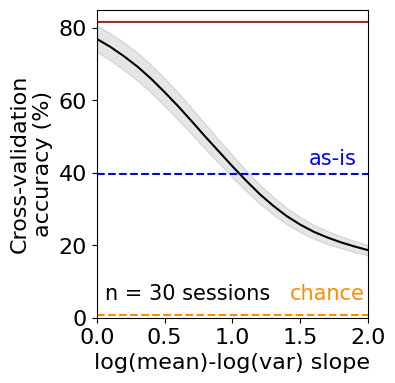

c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


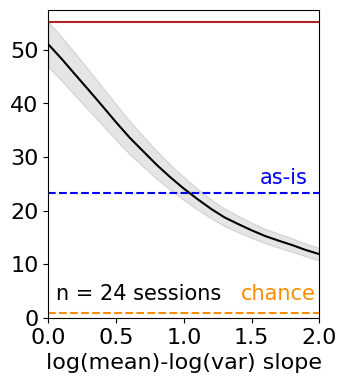

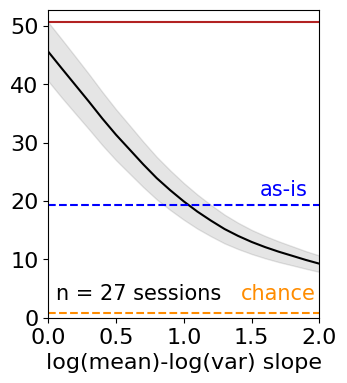

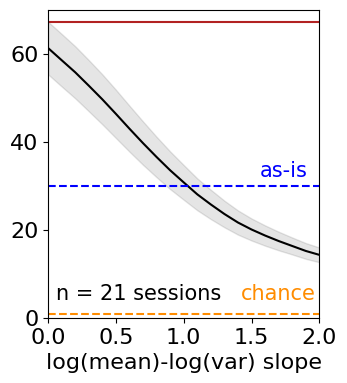

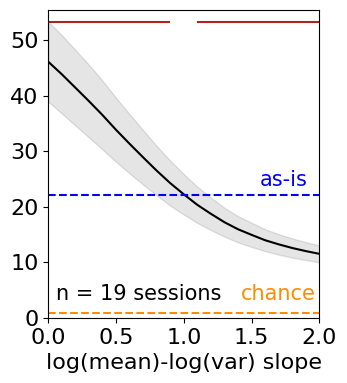

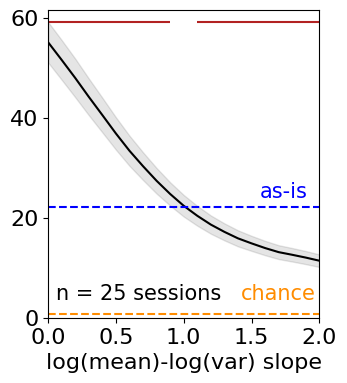

In [13]:
# decoding plot across slopes (ABO HVA, SVM)

# V1
decoder_type = 'SVM'
save_file_name = decoder_type + '_decoding_ABO_allstim_all.pickle' # randomness matched (slope 0~2), logit/SVM max_iter=1000/-1
save_file_name = decoder_type + '_decoding_ABO_allstim_all3.pickle' # randomness matched (slope 0~2), SVM max_iter=1000
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    decoding_ABO_all = pickle.load(f)

    # list_mean_confusion_test = decoding_ABO_all['list_mean_confusion_test'].copy()
    list_mean_accuracy = decoding_ABO_all['list_mean_accuracy'].copy()
    # list_mean_confusion_test_RRneuron2 = decoding_ABO_all['list_mean_confusion_test_RRneuron2'].copy()
    list_mean_accuracy_RRneuron2 = decoding_ABO_all['list_mean_accuracy_RRneuron2'].copy()

num_sess = 32
num_trial_types = 119

# Exclude low quality sessions (0, 6)
list_mean_accuracy = np.concatenate([np.array(list_mean_accuracy)[1:6], np.array(list_mean_accuracy)[7:]], axis=0)
list_mean_accuracy_RRneuron2 = np.concatenate([np.stack(list_mean_accuracy_RRneuron2)[:, 1:6], np.stack(list_mean_accuracy_RRneuron2)[:, 7:]], axis=1)

# # session filtering based on number of neurons
# list_num_neurons = np.array([list_rate_all[sess_ind].shape[0] for sess_ind in range(num_sess)])
# sess_inds_qual40_all = np.arange(num_sess)[list_num_neurons >= 40]
# list_mean_accuracy = np.array(list_mean_accuracy)[sess_inds_qual40_all].copy()
# list_mean_accuracy_RRneuron2 = np.stack(list_mean_accuracy_RRneuron2)[:, sess_inds_qual40_all].copy()

list_mean_accuracy = 100 * list_mean_accuracy
list_mean_accuracy_RRneuron2 = 100 * list_mean_accuracy_RRneuron2

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# Wilcoxon signed-rank test (RRneuron, ABO)
list_pvals_RRneuron2 = np.zeros(len(list_target_slopes)) # test accuracy
for slope_ind, slope in enumerate(list_target_slopes):
    list_pvals_RRneuron2[slope_ind] = list(wilcoxon(list_mean_accuracy, list_mean_accuracy_RRneuron2[slope_ind]))[1]
list_pvals_RRneuron2 = np.array(multipletests(list_pvals_RRneuron2, method='holm')[1]) # multiple comparisons correction

fig, axes = plt.subplots(1, 1, figsize=(3.5, 4))
axes = np.array(axes).flatten()

# As-is vs. RRneuron test accuracy (averaged across sessions)
    
# test accuracy

list_means_accuracy = np.array([np.mean(list_mean_accuracy_RRneuron2[slope_ind]) \
                       for slope_ind in range(len(list_target_slopes))])
list_errs_accuracy = np.array([sem(list_mean_accuracy_RRneuron2[slope_ind]) \
                      for slope_ind in range(len(list_target_slopes))])

axes[0].plot(list_target_slopes, list_means_accuracy, color='k')
# axes[0].errorbar(list_target_slopes, list_means_accuracy, yerr=list_errs_accuracy, \
#             fmt='.', color="m")
axes[0].fill_between(list_target_slopes, list_means_accuracy-list_errs_accuracy, \
                     list_means_accuracy+list_errs_accuracy, color='k', alpha=0.1)

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
axes[0].set_ylim(0, 85)
axes[0].set_yticks(np.arange(0, 81, 20))
annotate_lineplot_significance(list_target_slopes[list_pvals_RRneuron2 < 0.05], axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')
axes[0].axhline(np.mean(list_mean_accuracy), c='blue', linestyle='--') # as-is average
axes[0].axhline(1/num_trial_types*100, c='darkorange', linestyle='--') # chance level

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=16)
axes[0].set_ylabel('Cross-validation\naccuracy (%)', fontsize=16)
axes[0].tick_params('both', labelsize=16)

height = (np.mean(list_mean_accuracy) - axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.78, height+0.03), xycoords='axes fraction', fontsize=15, color='blue')
axes[0].annotate(f'n = {len(list_mean_accuracy)} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=15, color='k')
axes[0].annotate(f'chance', xy=(0.71, 0.06), xycoords='axes fraction', fontsize=15, color='darkorange')

axes[0].set_xlim(0, 2)

plt.show()

# HVA
decoder_type = 'SVM'
save_file_name = decoder_type + '_decoding_ABO_HVA_all.pickle' # randomness matched (slope 0~2), SVM max_iter=-1
save_file_name = decoder_type + '_decoding_ABO_HVA_all2.pickle' # randomness matched (slope 0~2), SVM max_iter=1000
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    decoding_ABO_all = pickle.load(f)

    list_mean_confusion_test_HVA = decoding_ABO_all['list_mean_confusion_test_HVA'].copy()
    list_mean_accuracy_HVA = decoding_ABO_all['list_mean_accuracy_HVA'].copy()
    list_mean_confusion_test_RRneuron_HVA2 = decoding_ABO_all['list_mean_confusion_test_RRneuron_HVA2'].copy()
    list_mean_accuracy_RRneuron_HVA2 = decoding_ABO_all['list_mean_accuracy_RRneuron_HVA2'].copy()

with open('resp_matrix_ep_HVA_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_HVA_allensdk = pickle.load(f)

    list_empty_sess2 = dc(resp_matrix_ep_HVA_allensdk['list_empty_sess2'])
    list_num_neurons_HVA = dc(resp_matrix_ep_HVA_allensdk['list_num_neurons_HVA'])
    # print(resp_matrix_ep_HVA_allensdk['tree_variables'])
    
list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# Wilcoxon signed-rank test (RRneuron, ABO HVA)
list_pvals_RRneuron_HVA2 = {hva: np.zeros(len(list_target_slopes)) for hva in list_HVA_names} # test accuracy
for area_ind, area in enumerate(list_HVA_names):
    for slope_ind, slope in enumerate(list_target_slopes):
        list_pvals_RRneuron_HVA2[area][slope_ind] = list(wilcoxon(list_mean_accuracy_HVA[area], list_mean_accuracy_RRneuron_HVA2[area][slope_ind]))[1]
    list_pvals_RRneuron_HVA2[area] = np.array(multipletests(list_pvals_RRneuron_HVA2[area], method='holm')[1]) # multiple comparisons correction
    
# As-is vs. RRneuron test accuracy (averaged across sessions)
for area_ind, area in enumerate(list_HVA_names):

    list_mean_accuracy_HVA_temp = dc(list_mean_accuracy_HVA[area])
    list_mean_accuracy_RRneuron_HVA2_temp = dc(list_mean_accuracy_RRneuron_HVA2[area])

    # exclude low quality sessions & sessions without neurons
    # list_lowq_sess_HVA_temp = list_lowq_sess_HVA[area][~np.isnan(list_lowq_sess_HVA[area])].copy()
    # mask_lowq = list_lowq_sess_HVA_temp <= 0.1
    mask_lowq = ~np.isin(list(sess_inds_mapBO.values()), list_invalid_sess_HVA[area]['natural_scenes'])
    mask_lowq = mask_lowq[list_num_neurons_HVA[area] > 0]
    list_mean_accuracy_HVA_temp = np.array(list_mean_accuracy_HVA[area])[mask_lowq].copy()
    list_mean_accuracy_RRneuron_HVA2_temp = np.stack(list_mean_accuracy_RRneuron_HVA2[area])[:, mask_lowq].copy()
    
    # # session filtering based on number of neurons
    # list_num_neurons = np.array(list_num_neurons_HVA[area]).copy()
    # list_num_neurons = list_num_neurons[list_num_neurons > 0].copy()
    # sess_inds_qual40_all = np.arange(list_num_neurons.shape[0])[list_num_neurons >= 40]
    # list_mean_accuracy_HVA_temp = np.array(list_mean_accuracy_HVA[area])[sess_inds_qual40_all].copy()
    # list_mean_accuracy_RRneuron_HVA2_temp = np.stack(list_mean_accuracy_RRneuron_HVA2[area])[:, sess_inds_qual40_all].copy()

    list_mean_accuracy_HVA_temp = 100 * list_mean_accuracy_HVA_temp
    list_mean_accuracy_RRneuron_HVA2_temp = 100 * list_mean_accuracy_RRneuron_HVA2_temp

    fig, axes = plt.subplots(1, 1, figsize=(3.5, 4))
    axes = np.array(axes).flatten()
    
    # test accuracy

    list_means_accuracy = np.array([np.mean(list_mean_accuracy_RRneuron_HVA2_temp[slope_ind])
                                    for slope_ind in range(len(list_target_slopes))])
    list_errs_accuracy = np.array([sem(list_mean_accuracy_RRneuron_HVA2_temp[slope_ind])
                                for slope_ind in range(len(list_target_slopes))])

    line, = axes[0].plot(list_target_slopes, list_means_accuracy, color='k')
    # axes[0].errorbar(list_target_slopes, list_means_accuracy, yerr=list_errs_accuracy, \
    #             fmt='.', color="m")
    axes[0].fill_between(list_target_slopes, list_means_accuracy-list_errs_accuracy, \
                        list_means_accuracy+list_errs_accuracy, color='k', alpha=0.1)

    # significance
    axes[0].set_ylim(0, axes[0].get_ylim()[1])
    # axes[0].set_ylim(0, 50)
    annotate_lineplot_significance(list_target_slopes[list_pvals_RRneuron_HVA2[area] < 0.05], axes=axes,
                                   ax_ind=0, line_height_ratio=0.96, color='firebrick')
    axes[0].axhline(np.mean(list_mean_accuracy_HVA_temp), c='blue', linestyle='--') # as-is average
    axes[0].axhline(1/num_trial_types*100, c='darkorange', linestyle='--') # chance level

    height = (np.mean(list_mean_accuracy_HVA_temp) - axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
    axes[0].annotate('as-is', xy=(0.78, height+0.03), xycoords='axes fraction', fontsize=15, color='blue')
    axes[0].annotate(f'n = {len(list_mean_accuracy_HVA_temp)} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=15, color='k')
    axes[0].annotate(f'chance', xy=(0.71, 0.06), xycoords='axes fraction', fontsize=15, color='darkorange')

    axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=16)
    # axes[0].set_ylabel('Cross-validation accuracy', fontsize=16)
    axes[0].tick_params('both', labelsize=16)
    
    axes[0].set_xlim(0, 2)

    # axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), prop={'size': 12})
    # axes[0].legend(loc=(0.02, 0.05), prop={'size': 12})

    plt.show()

## Figure S4A, S4B

In [14]:
# ABO pairwise & population-wise noise correlation (RRneuron) (~20 sec for each session)

list_target_slopes = [0, 1, 2] # Target slopes

num_sess = 32
n_pairs = 100 # Number of neuron pairs for pairwise correlation
num_trial_types = 119

# Iterate over all sessions

list_pair_nc_RRneuron2 = np.zeros((num_sess, n_pairs, len(list_target_slopes)+1, num_trial_types))
list_pc1_eig_asis2 = np.zeros((num_sess, num_trial_types))
list_pc1_eig_RRneuron3 = np.zeros((num_sess, len(list_target_slopes), num_trial_types))

for sess_ind, rate in enumerate(list_rate_all):
	if sess_ind == 7:
		print(f'session index: {sess_ind}')
		
		rate_sorted = rate.sort_index(axis=1)
		stm = rate_sorted.columns.copy()

		# Multiply by delta t to convert to spike counts
		rate_sorted = rate_sorted * 0.25

		# Create a counting dictionary for each stimulus
		all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
		stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

		# Compute mean & variance for each stimulus
		rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate_sorted)
		rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate_sorted)

		list_slopes_dr = pd.DataFrame(list_slopes_all_an_loglog[sess_ind], \
									columns=rate_sorted_mean_coll.columns).copy()
		
		# Prepare PCA
		n_components = 1
		pca = PCA(n_components=n_components)

		# Store explained variance ratio of PC1 for each stimulus
		list_pc1_eig_asis = np.zeros(rate_sorted_mean_coll.shape[1])
		for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):
			rate_tt = rate_sorted.loc[:, trial_type].copy()
			rate_tt_pca = pca.fit_transform(rate_tt.T).T
			list_pc1_eig_asis[trial_type_ind] = pca.explained_variance_ratio_[0]

		list_pc1_eig_asis2[sess_ind] = list_pc1_eig_asis.copy()

		list_rate_RRneuron = np.empty(len(list_target_slopes), dtype=object)
		list_pc1_eig_RRneuron2 = np.zeros((len(list_target_slopes), rate_sorted_mean_coll.shape[1]))
		for slope_ind, target_slope in enumerate(list_target_slopes):
			
			# Convert 0 to NaN (verified that cases of mean=0 and var=0 coincide exactly)
			rate_sorted_mean_coll[rate_sorted_mean_coll == 0] = np.nan
			rate_sorted_var_coll[rate_sorted_var_coll == 0] = np.nan

			print(f'target_slope = {target_slope:.1f}')

			# Change slope

			# calculate target variance
			var_estim_dr = pd.DataFrame(np.zeros((1, rate_sorted_var_coll.shape[1])), \
									columns=rate_sorted_var_coll.columns) 
			for trial_type in rate_sorted_var_coll.columns:
				var_estim_dr.loc[:, trial_type] = \
					np.nanmean(rate_sorted_var.loc[:, trial_type].values.flatten()) # nanmean
			# var_estim_dr = np.repeat(var_estim_dr, all_stm_counts, axis=1) 
			# print(var_estim_dr)

			# offset = var_estim_dr.div(rate_sorted_var_coll.pow(target_slope/list_slopes_dr.iloc[0, :], axis=1).mean(axis=0))\
			# .mul(pow(10, target_slope * list_slopes_dr.iloc[1, :] / list_slopes_dr.iloc[0, :])) # collapsed 
			offset = pow(10, (list_slopes_dr.iloc[0, :]-target_slope) * np.nanmean(np.log10(rate_sorted_mean_coll), axis=0) + list_slopes_dr.iloc[1, :]) 

			var_rs_noisy = \
				pow(10, np.log10(rate_sorted_var_coll).sub(list_slopes_dr.iloc[1, :], axis=1)\
					.div(list_slopes_dr.iloc[0, :], axis=1).mul(target_slope).add(np.log10(np.array(offset)), axis=1)) # collapsed
			var_rs_noisy = np.repeat(np.array(var_rs_noisy), all_stm_counts, axis=1) 
	
			# Compute changed residual and add back to the mean            
			rate_sorted_resid_dr = rate_sorted - rate_sorted_mean
			# rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
			#     .mul(np.sqrt(rate_sorted_mean)).mul(np.sqrt(FF_estim_dr), axis=1)
			rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
			    .mul(np.sqrt(var_rs_noisy))
			# print(rate_resid_RRneuron_dr)
			rate_RRneuron_dr = rate_sorted_mean + rate_resid_RRneuron_dr
			rate_RRneuron_dr[rate_RRneuron_dr.isna()] = 0 # convert NaN to 0!    

			# Compute mean and variance of slope-changed data
			rate_mean_RRneuron_coll, rate_var_RRneuron_coll = \
			    compute_mean_var_trial_collapse(stm_cnt_dict, rate_RRneuron_dr)
			# FF_RRneuron = rate_var_RRneuron_dr.div(rate_mean_RRneuron_dr)
			# print(FF_RRneuron)
			# print(rate_var_RRneuron_dr)

			list_rate_RRneuron[slope_ind] = rate_RRneuron_dr.copy()
													
			# Store explained variance ratio of PC1 for each stimulus
			list_pc1_eig_RRneuron = np.zeros(rate_sorted_mean_coll.shape[1])
			for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):
				rate_tt = rate_RRneuron_dr.loc[:, trial_type].copy()
				try:
					rate_tt_pca = pca.fit_transform(rate_tt.T).T
					list_pc1_eig_RRneuron[trial_type_ind] = pca.explained_variance_ratio_[0]
				except:
					list_pc1_eig_RRneuron[trial_type_ind] = np.nan
			
			list_pc1_eig_RRneuron2[slope_ind] = list_pc1_eig_RRneuron.copy()

		list_pc1_eig_RRneuron3[sess_ind] = list_pc1_eig_RRneuron2.copy()

		# pairwise noise correlation

		# Iterate over random neuron pairs
		list_pair_nc_RRneuron = np.full((n_pairs, len(list_target_slopes)+1, num_trial_types), np.nan) # as-is, RRneuron
		np.random.seed(sess_ind)
		for pair_ind in range(n_pairs):
			neu_pair = np.random.choice(rate_sorted.index, 2, replace=False)

			# Collect noise correlations per stimulus
			pair_nc_RRneuron = np.full((len(list_target_slopes)+1, num_trial_types), np.nan) 
			for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):
				
				# as-is
				pair_nc_RRneuron[-1, trial_type_ind] = np.corrcoef(rate_sorted.loc[neu_pair[0], trial_type], rate_sorted.loc[neu_pair[1], trial_type])[0, 1]
				
				# slope-changed
				for slope_ind, target_slope in enumerate(list_target_slopes):
					bool_notnan = np.logical_and(~np.isnan(list_rate_RRneuron[slope_ind].loc[neu_pair[0], trial_type]), ~np.isnan(list_rate_RRneuron[slope_ind].loc[neu_pair[1], trial_type]))
					pair_nc_RRneuron[slope_ind, trial_type_ind] = np.corrcoef(list_rate_RRneuron[slope_ind].loc[neu_pair[0], trial_type].loc[bool_notnan],
															   list_rate_RRneuron[slope_ind].loc[neu_pair[1], trial_type].loc[bool_notnan])[0, 1]
			list_pair_nc_RRneuron[pair_ind] = pair_nc_RRneuron.copy()
		
		list_pair_nc_RRneuron2[sess_ind] = list_pair_nc_RRneuron.copy()

session index: 7
target_slope = 0.0
target_slope = 1.0
target_slope = 2.0


c:\Users\USER\anaconda3\envs\final_test\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\USER\anaconda3\envs\final_test\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


7
64


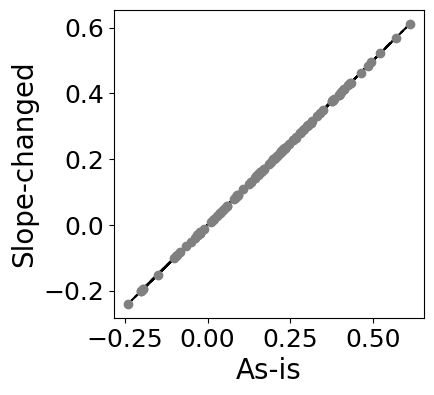

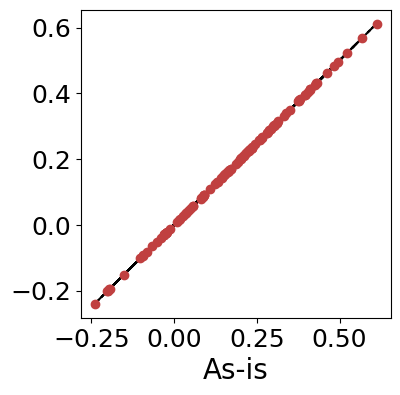

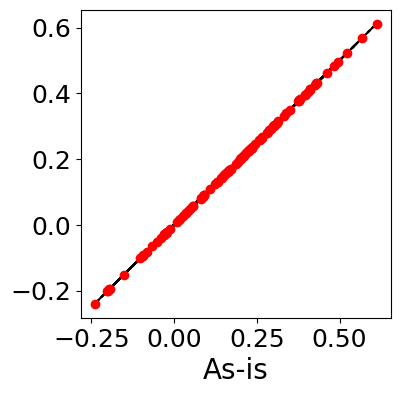

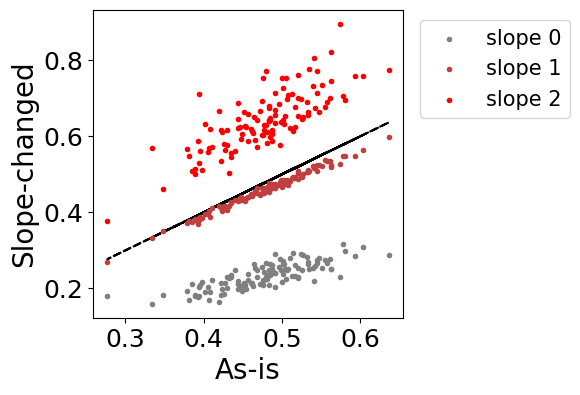

In [15]:
list_target_slopes = [0, 1, 2]
num_sess = 32
n_pairs = 100

# pairwise noise correlation scatterplot (as-is vs. RRneuron)

# Define a custom colormap from gray to red
gray_to_red = mcolors.LinearSegmentedColormap.from_list("gray_to_red", ["gray", "red"])

num_lines = 3 # Number of slopes to plot
norm = mcolors.Normalize(vmin=0, vmax=num_lines-1)

# scatterplot
sess_ind = np.random.choice(range(num_sess), 1)[0]
sess_ind = 7
print(sess_ind)

pair_ind = np.random.choice(range(n_pairs), 1)[0]
print(pair_ind)

for slope_ind, target_slope in enumerate(list_target_slopes):
	fig, axes = plt.subplots(figsize=(4, 4))
	axes = np.array(axes).flatten()

	axes[0].scatter(list_pair_nc_RRneuron2[sess_ind, pair_ind, -1], list_pair_nc_RRneuron2[sess_ind, pair_ind, slope_ind],
					marker='o', color=gray_to_red(norm(slope_ind)), label=f'slope {target_slope:.1f}', zorder=2)
	
	# correlation between as-is and RRneuron
	bool_notnan = np.logical_and(~np.isnan(list_pair_nc_RRneuron2[sess_ind, pair_ind, -1]), ~np.isnan(list_pair_nc_RRneuron2[sess_ind, pair_ind, slope_ind]))
	corr = np.corrcoef(list_pair_nc_RRneuron2[sess_ind, pair_ind, -1][bool_notnan], list_pair_nc_RRneuron2[sess_ind, pair_ind, slope_ind][bool_notnan])[0, 1]

	# y=x line
	axes[0].plot(list_pair_nc_RRneuron2[sess_ind, pair_ind, -1], list_pair_nc_RRneuron2[sess_ind, pair_ind, -1],
				 color='k', linestyle='--', zorder=1)

	# min_, max_ = np.nanmin(list_pair_nc_RRneuron2[sess_ind, pair_ind]), np.nanmax(list_pair_nc_RRneuron2[sess_ind, pair_ind])
	# axes[0].set_xlim(min_, max_)
	# axes[0].set_ylim(min_, max_)

	axes[0].set_xlabel('As-is', fontsize=20)
	if slope_ind == 0:
		axes[0].set_ylabel(f'Slope-changed', fontsize=20)
	axes[0].tick_params('both', labelsize=18)
	# axes[0].annotate(f'r = {corr:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=18)

	# axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), prop={'size': 12})

	plt.show()

# popwise noise correlation (PC1 explained variance ratio) scatterplot (as-is vs. RRneuron)

fig, axes = plt.subplots(figsize=(4, 4))
axes = np.array(axes).flatten()

# scatterplot
for slope_ind, target_slope in enumerate(list_target_slopes):
	axes[0].scatter(list_pc1_eig_asis2[sess_ind], list_pc1_eig_RRneuron3[sess_ind, slope_ind],
					marker='.', color=gray_to_red(norm(slope_ind)), label=f'slope {target_slope:.0f}', zorder=2)

# y=x line
axes[0].plot(list_pc1_eig_asis2[sess_ind], list_pc1_eig_asis2[sess_ind],
			 color='k', linestyle='--', zorder=1)

axes[0].set_xlabel('As-is', fontsize=20)
axes[0].set_ylabel('Slope-changed', fontsize=20)
axes[0].tick_params('both', labelsize=18)

axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), prop={'size': 15})

plt.show()